In [15]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

from datetime import datetime, timedelta 

In [2]:
# 地球半径（单位：米）
EARTH_RADIUS = 6371000

def generate_track(start_time, start_lat, start_lon, start_speed, start_heading, motion_type, SNR_track, SNR_time, acceleration=None, turn_rate=None, num_points=200):
    """
    生成航迹数据
    :param start_time: 起始时间（datetime对象）
    :param start_lat: 起始纬度（度）
    :param start_lon: 起始经度（度）
    :param start_speed: 起始速度（米/秒）
    :param start_heading: 起始航向（度，0表示正北，90表示正东）
    :param motion_type: 运动类型（'uniform'：匀速，'acceleration'：匀加速，'turn'：转弯）
    :param num_points: 航迹点数
    :return: 包含时间、经纬度、航速和航向的DataFrame
    """
    time = np.linspace(start_time, start_time + num_points, num_points)
    lat = np.zeros(num_points)
    lon = np.zeros(num_points)
    speed = np.zeros(num_points)
    heading = np.zeros(num_points)

    lat[0] = start_lat
    lon[0] = start_lon
    speed[0] = start_speed
    heading[0] = start_heading

    for i in range(1, num_points):
        dt = time[i] - time[i - 1]  # 时间间隔为1秒

        if motion_type == 'uniform':
            # 匀速运动
            speed[i] = start_speed
            heading[i] = start_heading
        elif motion_type == 'acceleration':
            # 匀加速运动，假设加速度为0.1 m/s^2
            speed[i] = speed[i-1] + acceleration * dt
            heading[i] = start_heading
        elif motion_type == 'turn':
            # 转弯运动，假设转弯速率为1度/秒
            speed[i] = start_speed
            heading[i] = heading[i-1] + turn_rate * dt

        # 计算经纬度变化
        distance = speed[i] * dt
        angular_distance = distance / EARTH_RADIUS

        # 将航向转换为弧度
        heading_rad = np.radians(heading[i])

        # 计算新的纬度
        lat[i] = lat[i-1] + np.degrees(angular_distance * np.cos(heading_rad))

        # 计算新的经度
        lon[i] = lon[i-1] + np.degrees(angular_distance * np.sin(heading_rad) / np.cos(np.radians(lat[i-1])))

    # 创建DataFrame
    track_data = pd.DataFrame({
        'time': time,
        'latitude': lat,
        'longitude': lon,
        'speed': speed,
        'heading': heading
    })
    track_data["time"] = add_awgn(track_data["time"], SNR_time, "uniform")
    track_data["latitude"] = add_awgn(track_data["latitude"], SNR_track)
    track_data["longitude"] = add_awgn(track_data["longitude"], SNR_track)
    
    return track_data


def add_awgn(signal, snr_db, noise_type="normal"):  
    """  
    为输入信号添加加性高斯白噪声（AWGN）。  

    参数：  
        signal: 输入信号（NumPy 数组）  
        snr_db: 信噪比（以分贝为单位）  

    返回：  
        受噪声影响的信号  
    """  
    # 计算信号的功率  
    signal_power = np.mean(signal ** 2)  
    
    # 将信噪比从分贝转换为线性  
    snr_linear = 10 ** (snr_db / 10.0)  

    # 计算噪声的功率  
    noise_power = signal_power / snr_linear  

    # 生成噪声 
    if (noise_type == "normal"): 
        noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    if (noise_type == "uniform"):
        noise = np.sqrt(noise_power) * np.random.uniform(0, 1, size=signal.shape)
    # 返回添加了 AWGN 的信号  
    return signal + noise  

In [3]:
# 中断
def cut_tracks(track, cut_points, min_points):
    cut_index = random.sample(list(range(min_points, int(len(track) - cut_points - min_points))), 1)[0]
    return [track.iloc[0:cut_index], track.iloc[cut_index + cut_points:]]

In [4]:
# 生成随机航迹
N_tracks = 100
num_points = 200
start_time_list = [30, 100]
starting_lat_range = [28, 30]
staring_lon_range = [100, 105]
starting_speed_range = [10, 50]
accelation_range = [0.1, 1]
turn_rate_range= [0.1, 1.5]
starting_heading_range = [0, 360]

SNR_track = 120
SNR_time = 30

data_uniform_track = []
data_accelation_track = []
data_turned_track = []
for i in range(N_tracks):
    # 生成均匀航迹
    start_time = np.random.uniform(start_time_list[0], start_time_list[1])
    start_lat = np.random.uniform(starting_lat_range[0], starting_lat_range[1])
    start_lon = np.random.uniform(staring_lon_range[0], staring_lon_range[1])
    start_speed = np.random.uniform(starting_speed_range[0], starting_speed_range[1])
    start_heading = np.random.uniform(starting_heading_range[0], starting_heading_range[1])
    track_temp = generate_track(start_time, start_lat, start_lon, start_speed, start_heading, motion_type="uniform", SNR_track=SNR_track, SNR_time=SNR_time, acceleration=None, turn_rate=None, num_points=num_points)
    data_uniform_track.append(track_temp)
    
    # 生成加速航迹
    start_time = np.random.uniform(start_time_list[0], start_time_list[1])
    start_lat = np.random.uniform(starting_lat_range[0], starting_lat_range[1])
    start_lon = np.random.uniform(staring_lon_range[0], staring_lon_range[1])
    start_speed = np.random.uniform(starting_speed_range[0], starting_speed_range[1])
    start_heading = np.random.uniform(starting_heading_range[0], starting_heading_range[1])
    acceleration = np.random.uniform(accelation_range[0], accelation_range[1])
    track_temp = generate_track(start_time, start_lat, start_lon, start_speed, start_heading, motion_type="acceleration", SNR_track=SNR_track, SNR_time=SNR_time, acceleration=acceleration, turn_rate=None, num_points=num_points)
    data_accelation_track.append(track_temp)

    # 生成转弯航迹
    start_time = np.random.uniform(start_time_list[0], start_time_list[1])
    start_lat = np.random.uniform(starting_lat_range[0], starting_lat_range[1])
    start_lon = np.random.uniform(staring_lon_range[0], staring_lon_range[1])
    start_speed = np.random.uniform(starting_speed_range[0], starting_speed_range[1])
    start_heading = np.random.uniform(starting_heading_range[0], starting_heading_range[1])
    acceleration = np.random.uniform(accelation_range[0], accelation_range[1])
    turn_rate = np.random.uniform(turn_rate_range[0], turn_rate_range[1])
    track_temp = generate_track(start_time, start_lat, start_lon, start_speed, start_heading, motion_type="turn", SNR_track=SNR_track, SNR_time=SNR_time, acceleration=acceleration, turn_rate=turn_rate, num_points=num_points)
    data_turned_track.append(track_temp)


In [5]:
# 航迹中断
min_points = 50
cut_points_range = [20, num_points - 2 * min_points]  # 不超过num_points - 2 * min_points

data_uniform_track_cut = []
data_accelation_track_cut = []
data_turned_track_cut = []
for i in range(N_tracks):
    # 均匀航迹
    cut_points = int(np.random.uniform(cut_points_range[0], cut_points_range[1]))
    data_uniform_track_cut.append(cut_tracks(data_uniform_track[i], cut_points, min_points))
    # 加速航迹
    cut_points = int(np.random.uniform(cut_points_range[0], cut_points_range[1]))
    data_accelation_track_cut.append(cut_tracks(data_accelation_track[i], cut_points, min_points))
    # 转弯航迹
    cut_points = int(np.random.uniform(cut_points_range[0], cut_points_range[1]))
    data_turned_track_cut.append(cut_tracks(data_turned_track[i], cut_points, min_points))

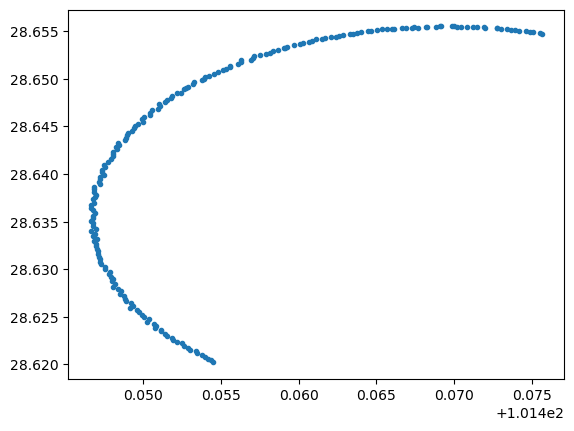

In [6]:
plt.plot(track_temp["longitude"], track_temp["latitude"], ".")

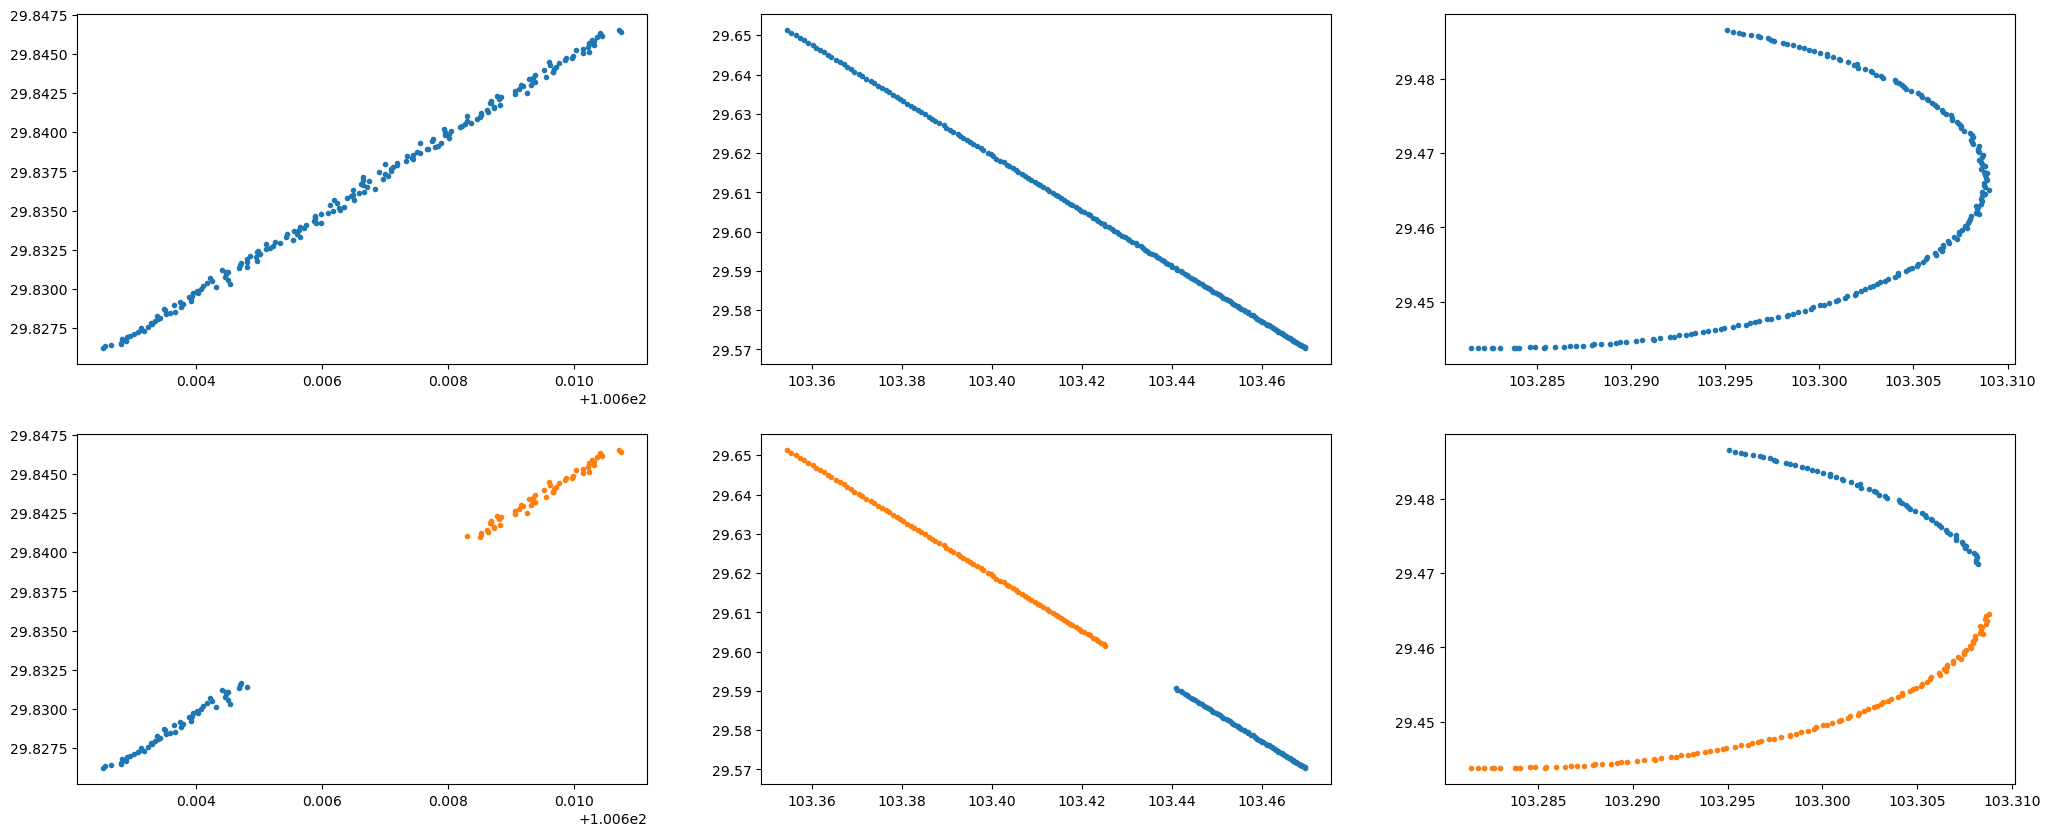

In [7]:
index = random.sample(list(range(0, N_tracks)), 1)[0]

plt.figure(figsize=[25, 10])
plt.subplot(2, 3, 1)
plt.plot(data_uniform_track[index]["longitude"], data_uniform_track[index]["latitude"], ".")
plt.subplot(2, 3, 2)
plt.plot(data_accelation_track[index]["longitude"], data_accelation_track[index]["latitude"], ".")
plt.subplot(2, 3, 3)
plt.plot(data_turned_track[index]["longitude"], data_turned_track[index]["latitude"], ".")
plt.subplot(2, 3, 4)
plt.plot(data_uniform_track_cut[index][0]["longitude"], data_uniform_track_cut[index][0]["latitude"], ".")
plt.plot(data_uniform_track_cut[index][1]["longitude"], data_uniform_track_cut[index][1]["latitude"], ".")
plt.subplot(2, 3, 5)
plt.plot(data_accelation_track_cut[index][0]["longitude"], data_accelation_track_cut[index][0]["latitude"], ".")
plt.plot(data_accelation_track_cut[index][1]["longitude"], data_accelation_track_cut[index][1]["latitude"], ".")
plt.subplot(2, 3, 6)
plt.plot(data_turned_track_cut[index][0]["longitude"], data_turned_track_cut[index][0]["latitude"], ".")
plt.plot(data_turned_track_cut[index][1]["longitude"], data_turned_track_cut[index][1]["latitude"], ".")

(29.5, 29.8)

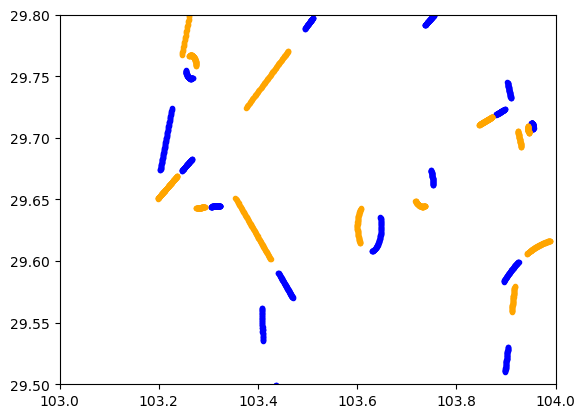

In [9]:
for i in range(N_tracks):
    plt.plot(data_uniform_track_cut[i][0]["longitude"], data_uniform_track_cut[i][0]["latitude"], ".", color="blue")
    plt.plot(data_uniform_track_cut[i][1]["longitude"], data_uniform_track_cut[i][1]["latitude"], ".", color="orange")
    plt.plot(data_accelation_track_cut[i][0]["longitude"], data_accelation_track_cut[i][0]["latitude"], ".", color="blue")
    plt.plot(data_accelation_track_cut[i][1]["longitude"], data_accelation_track_cut[i][1]["latitude"], ".", color="orange")
    plt.plot(data_turned_track_cut[i][0]["longitude"], data_turned_track_cut[i][0]["latitude"], ".", color="blue")
    plt.plot(data_turned_track_cut[i][1]["longitude"], data_turned_track_cut[i][1]["latitude"], ".", color="orange")

plt.xlim([103, 104])
plt.ylim([29.5, 29.8])

In [50]:
# 保存
path_ori = "../Data/original/"
path_splitted_1 = "../Data/splitted_before/"
path_splitted_2 = "../Data/splitted_after/"

for i in range(N_tracks):
    # 均匀
    path_temp = f"均匀_{i}.csv"
    path_temp_1 = f"均匀_{i}_0.csv"
    path_temp_2 = f"均匀_{i}_1.csv"
    data_uniform_track[i].to_csv(path_ori + path_temp, index=False)
    data_uniform_track_cut[i][0].to_csv(path_splitted_1 + path_temp_1, index=False)
    data_uniform_track_cut[i][1].to_csv(path_splitted_2 + path_temp_2, index=False)
    # 加速
    path_temp = f"加速_{i}.csv"
    path_temp_1 = f"加速_{i}_0.csv"
    path_temp_2 = f"加速_{i}_1.csv"
    data_accelation_track[i].to_csv(path_ori + path_temp, index=False)
    data_accelation_track_cut[i][0].to_csv(path_splitted_1 + path_temp_1, index=False)   
    data_accelation_track_cut[i][1].to_csv(path_splitted_2 + path_temp_2, index=False)   
    # 转弯
    path_temp = f"转弯_{i}.csv"
    path_temp_1 = f"转弯_{i}_0.csv"
    path_temp_2 = f"转弯_{i}_1.csv"
    data_turned_track[i].to_csv(path_ori + path_temp, index=False)
    data_turned_track_cut[i][0].to_csv(path_splitted_1 + path_temp_1, index=False)
    data_turned_track_cut[i][1].to_csv(path_splitted_2 + path_temp_2, index=False)

In [48]:
import os
import numpy as np
import pandas as pd

# 数据文件夹路径
path_ori = "../Data/original/"

def load_tracks(path_ori):
    tracks = np.zeros((300, 200, 6))  # 存储所有航迹数据，形状 (300, 200, 6)

    # 获取所有 csv 文件
    files = sorted([f for f in os.listdir(path_ori) if f.endswith(".csv")], key=lambda x: int(x.split("_")[1].split(".")[0]))

    for i, file in enumerate(files):
        file_path = os.path.join(path_ori, file)
        df = pd.read_csv(file_path)

        # 确保列的顺序正确
        df = df[["time", "latitude", "longitude", "speed", "heading"]]

        # 为每条航迹分配 ID，ID 编号从 0 到 299
        track_id = i  # 从 0 开始编号，每个文件的航迹 ID 都不重复

        # 转换为 numpy 数组，并添加 ID 列
        track_data = df.to_numpy()
        track_data = np.hstack((np.full((track_data.shape[0], 1), track_id), track_data))

        # 存入固定大小数组
        tracks[i, :, :] = track_data

    return tracks

# 读取数据
tracks = load_tracks(path_ori)

# 检查数据形状
print(f"Total Tracks: {tracks.shape[0]}")
print(f"Track Shape: {tracks.shape}")
print(f"First Track Example: {tracks[0, :5, :]}")



Total Tracks: 300
Track Shape: (300, 200, 6)
First Track Example: [[  0.          42.98061301  28.5125763  104.93228857  39.98275836
  276.83282476]
 [  0.          46.17544761  28.51263969 104.93162325  40.33183744
  276.83282476]
 [  0.          49.0522266   28.51263724 104.93123944  40.68091652
  276.83282476]
 [  0.          47.31439312  28.51268398 104.93095126  41.02999559
  276.83282476]
 [  0.          49.1072539   28.5127885  104.9304295   41.37907467
  276.83282476]]


In [53]:
tracks[:,:,0]

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       ...,
       [297., 297., 297., ..., 297., 297., 297.],
       [298., 298., 298., ..., 298., 298., 298.],
       [299., 299., 299., ..., 299., 299., 299.]])

In [57]:
import numpy as np

# 设置随机种子，保证结果可复现
np.random.seed(42)

def generate_interrupted_data(input_data, interruption_start_idx=100, interruption_rate=0.1):
    """
    从每条航迹的第`interruption_start_idx`个点开始，随机决定后续的哪些点中断（设为空）。
    :param input_data: 原始航迹数据 (300, 200, 6)
    :param interruption_start_idx: 从第几个点开始中断（例如100表示从第100个点开始中断）
    :param interruption_rate: 中断后续点的比例 (0-1之间)
    :return: 中断后的输入数据和目标数据
    """
    N, T, D = input_data.shape  # N是航迹条数，T是每条航迹的时间点数，D是每个时间点的特征数
    interrupted_input = input_data.copy()
    target_data = input_data.copy()  # 目标数据是原始数据（没有中断的部分）

    # 遍历每条航迹数据
    for i in range(N):
        # 从第`interruption_start_idx`个点开始，随机决定哪些点需要中断
        if interruption_start_idx < T:
            # 随机选择一个点，在`interruption_start_idx`之后的位置开始中断
            interruption_start = np.random.randint(interruption_start_idx, T)

            # 生成中断掩码：从中断位置开始到最后，设为空（NaN）
            interrupted_input[i, interruption_start:, :] = np.nan  # 可以改成0或者其他值
            
            # 目标数据不受影响，仍然是原始的航迹数据
            # 如果需要，你也可以在这里设置目标数据的某些部分为空，视需求而定

    return interrupted_input, target_data

# 示例：生成300条航迹，每条航迹200个点，每个点6个特征的数据
train_input = tracks  # 原始输入数据
train_target = train_input.copy()  # 目标数据与输入数据相同

# 中断数据：从第100个点开始随机中断，后续数据设为空
interrupted_train_input, interrupted_train_target = generate_interrupted_data(train_input)

print(interrupted_train_input.shape)  # (300, 200, 6)
print(interrupted_train_target.shape)  # (300, 200, 6)

# 输出示例，查看一些中断数据
print(interrupted_train_input[0, 100:110, :])  # 输出第一个航迹从第100个点开始的10个时间点的数据


(300, 200, 6)
(300, 200, 6)
[[  0.         143.82269828  28.51876241 104.8731165   74.89066611
  276.83282476]
 [  0.         143.92546094  28.51885813 104.87270408  75.23974519
  276.83282476]
 [  0.         145.52853297  28.5189485  104.87186251  75.58882427
  276.83282476]
 [  0.         148.77998008  28.51905786 104.87093274  75.93790335
  276.83282476]
 [  0.         149.82132242  28.51911674 104.87020566  76.28698242
  276.83282476]
 [  0.         148.64031868  28.51912816 104.86960483  76.6360615
  276.83282476]
 [  0.         151.87876921  28.51929319 104.86869516  76.98514058
  276.83282476]
 [  0.         151.8672153   28.51936659 104.86781956  77.33421966
  276.83282476]
 [  0.         154.2989537   28.51947992 104.86688829  77.68329873
  276.83282476]
 [  0.         152.07542741  28.51950296 104.86607277  78.03237781
  276.83282476]]


In [59]:
interrupted_train_input[0][100:200,:]

array([[  0.        , 143.82269828,  28.51876241, 104.8731165 ,
         74.89066611, 276.83282476],
       [  0.        , 143.92546094,  28.51885813, 104.87270408,
         75.23974519, 276.83282476],
       [  0.        , 145.52853297,  28.5189485 , 104.87186251,
         75.58882427, 276.83282476],
       [  0.        , 148.77998008,  28.51905786, 104.87093274,
         75.93790335, 276.83282476],
       [  0.        , 149.82132242,  28.51911674, 104.87020566,
         76.28698242, 276.83282476],
       [  0.        , 148.64031868,  28.51912816, 104.86960483,
         76.6360615 , 276.83282476],
       [  0.        , 151.87876921,  28.51929319, 104.86869516,
         76.98514058, 276.83282476],
       [  0.        , 151.8672153 ,  28.51936659, 104.86781956,
         77.33421966, 276.83282476],
       [  0.        , 154.2989537 ,  28.51947992, 104.86688829,
         77.68329873, 276.83282476],
       [  0.        , 152.07542741,  28.51950296, 104.86607277,
         78.03237781, 276.8

array([[ 42.98061301,  28.5125763 , 104.93228857,  39.98275836,
        276.83282476],
       [ 46.17544761,  28.51263969, 104.93162325,  40.33183744,
        276.83282476],
       [ 49.0522266 ,  28.51263724, 104.93123944,  40.68091652,
        276.83282476],
       [ 47.31439312,  28.51268398, 104.93095126,  41.02999559,
        276.83282476],
       [ 49.1072539 ,  28.5127885 , 104.9304295 ,  41.37907467,
        276.83282476],
       [ 48.01634037,  28.51281659, 104.93024426,  41.72815375,
        276.83282476],
       [ 52.34977086,  28.51283749, 104.92970514,  42.07723283,
        276.83282476],
       [ 52.69029112,  28.51290369, 104.92924396,  42.4263119 ,
        276.83282476],
       [ 51.87812285,  28.51298165, 104.92876398,  42.77539098,
        276.83282476],
       [ 52.47808542,  28.51299863, 104.92845318,  43.12447006,
        276.83282476],
       [ 54.08501615,  28.51299968, 104.9278194 ,  43.47354914,
        276.83282476],
       [ 57.05577673,  28.51310098, 104.927